**Import Libraries**

In [1]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42

# Parameteres fine tuning
LEARNING_RATE = 0.01
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 100
BATCH_SIZE = 16
PATIENCE = 10

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Split based on patients
unique_patients = labels_df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = labels_df[labels_df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = labels_df[labels_df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((256, 256)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomResizedCrop(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((256, 256)),

    transforms.CenterCrop(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)

# **Step 3: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [11]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        # Replace the classification head to match the number of disease labels
        self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier()
model.to(device)

MultiLabelClassifier(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-

**Use Multiple GPUs**

In [12]:
model = nn.DataParallel(model)

# **Step 4: Train the Model**

**Step 1: Train Classification Head Only**

In [13]:
# Freeze the backbone parameters
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

In [14]:
# Only the classifier parameters will be updated
criterion = nn.BCEWithLogitsLoss()
optimizer_head = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=0.1, patience=5, mode='min')

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    patience = 5
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler once per epoch.
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience} epochs")
                break

    model.load_state_dict(torch.load('best_model.pt'))
    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_head, PATIENCE, epochs=EPOCHS)

Epoch 1/100:   0%|          | 0/4914 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 701/701 [00:17<00:00, 40.35it/s, Loss=0.156] 


Epoch 1/100 | Training Loss: 0.1834 | Validation Loss: 0.1711 | Mean Validation AUC: 0.6700
New best model saved with Mean Validation AUC: 0.6700


Epoch 2/100: 100%|██████████| 701/701 [00:17<00:00, 39.75it/s, Loss=0.154] 


Epoch 2/100 | Training Loss: 0.1750 | Validation Loss: 0.1687 | Mean Validation AUC: 0.7080
New best model saved with Mean Validation AUC: 0.7080


Epoch 3/100: 100%|██████████| 701/701 [00:17<00:00, 40.48it/s, Loss=0.156] 


Epoch 3/100 | Training Loss: 0.1733 | Validation Loss: 0.1671 | Mean Validation AUC: 0.7205
New best model saved with Mean Validation AUC: 0.7205


Epoch 4/100: 100%|██████████| 701/701 [00:17<00:00, 40.27it/s, Loss=0.156] 


Epoch 4/100 | Training Loss: 0.1726 | Validation Loss: 0.1664 | Mean Validation AUC: 0.7257
New best model saved with Mean Validation AUC: 0.7257


Epoch 5/100: 100%|██████████| 701/701 [00:17<00:00, 39.26it/s, Loss=0.149] 


Epoch 5/100 | Training Loss: 0.1720 | Validation Loss: 0.1660 | Mean Validation AUC: 0.7299
New best model saved with Mean Validation AUC: 0.7299


Epoch 6/100: 100%|██████████| 701/701 [00:17<00:00, 40.41it/s, Loss=0.152] 


Epoch 6/100 | Training Loss: 0.1718 | Validation Loss: 0.1663 | Mean Validation AUC: 0.7331
New best model saved with Mean Validation AUC: 0.7331


Epoch 7/100: 100%|██████████| 701/701 [00:17<00:00, 39.19it/s, Loss=0.152] 


Epoch 7/100 | Training Loss: 0.1715 | Validation Loss: 0.1658 | Mean Validation AUC: 0.7343
New best model saved with Mean Validation AUC: 0.7343


Epoch 8/100: 100%|██████████| 701/701 [00:17<00:00, 39.77it/s, Loss=0.149] 


Epoch 8/100 | Training Loss: 0.1715 | Validation Loss: 0.1652 | Mean Validation AUC: 0.7361
New best model saved with Mean Validation AUC: 0.7361


Epoch 9/100: 100%|██████████| 701/701 [00:17<00:00, 40.16it/s, Loss=0.147] 


Epoch 9/100 | Training Loss: 0.1710 | Validation Loss: 0.1652 | Mean Validation AUC: 0.7379
New best model saved with Mean Validation AUC: 0.7379


Epoch 10/100: 100%|██████████| 701/701 [00:18<00:00, 38.59it/s, Loss=0.147] 


Epoch 10/100 | Training Loss: 0.1711 | Validation Loss: 0.1651 | Mean Validation AUC: 0.7369


Epoch 11/100: 100%|██████████| 701/701 [00:17<00:00, 39.69it/s, Loss=0.147] 


Epoch 11/100 | Training Loss: 0.1708 | Validation Loss: 0.1654 | Mean Validation AUC: 0.7393
New best model saved with Mean Validation AUC: 0.7393


Epoch 12/100: 100%|██████████| 701/701 [00:17<00:00, 39.97it/s, Loss=0.144] 


Epoch 12/100 | Training Loss: 0.1709 | Validation Loss: 0.1652 | Mean Validation AUC: 0.7401
New best model saved with Mean Validation AUC: 0.7401


Epoch 13/100: 100%|██████████| 701/701 [00:17<00:00, 39.27it/s, Loss=0.143] 


Epoch 13/100 | Training Loss: 0.1707 | Validation Loss: 0.1648 | Mean Validation AUC: 0.7397


Epoch 14/100: 100%|██████████| 701/701 [00:17<00:00, 40.87it/s, Loss=0.141] 


Epoch 14/100 | Training Loss: 0.1705 | Validation Loss: 0.1649 | Mean Validation AUC: 0.7405
New best model saved with Mean Validation AUC: 0.7405


Epoch 15/100: 100%|██████████| 701/701 [00:17<00:00, 39.98it/s, Loss=0.146] 


Epoch 15/100 | Training Loss: 0.1707 | Validation Loss: 0.1649 | Mean Validation AUC: 0.7406
New best model saved with Mean Validation AUC: 0.7406


Epoch 16/100: 100%|██████████| 701/701 [00:17<00:00, 40.00it/s, Loss=0.147] 


Epoch 16/100 | Training Loss: 0.1705 | Validation Loss: 0.1654 | Mean Validation AUC: 0.7393


Epoch 17/100: 100%|██████████| 701/701 [00:17<00:00, 39.66it/s, Loss=0.143] 


Epoch 17/100 | Training Loss: 0.1706 | Validation Loss: 0.1649 | Mean Validation AUC: 0.7403


Epoch 18/100: 100%|██████████| 701/701 [00:17<00:00, 40.36it/s, Loss=0.144] 


Epoch 18/100 | Training Loss: 0.1705 | Validation Loss: 0.1643 | Mean Validation AUC: 0.7425
New best model saved with Mean Validation AUC: 0.7425


Epoch 19/100: 100%|██████████| 701/701 [00:17<00:00, 40.29it/s, Loss=0.144] 


Epoch 19/100 | Training Loss: 0.1702 | Validation Loss: 0.1659 | Mean Validation AUC: 0.7426
New best model saved with Mean Validation AUC: 0.7426


Epoch 20/100: 100%|██████████| 701/701 [00:17<00:00, 39.90it/s, Loss=0.141] 


Epoch 20/100 | Training Loss: 0.1702 | Validation Loss: 0.1646 | Mean Validation AUC: 0.7413


Epoch 21/100: 100%|██████████| 701/701 [00:17<00:00, 40.59it/s, Loss=0.139] 


Epoch 21/100 | Training Loss: 0.1704 | Validation Loss: 0.1645 | Mean Validation AUC: 0.7435
New best model saved with Mean Validation AUC: 0.7435


Epoch 22/100: 100%|██████████| 701/701 [00:17<00:00, 39.85it/s, Loss=0.142] 


Epoch 22/100 | Training Loss: 0.1703 | Validation Loss: 0.1646 | Mean Validation AUC: 0.7435


Epoch 23/100: 100%|██████████| 701/701 [00:17<00:00, 39.56it/s, Loss=0.139] 


Epoch 23/100 | Training Loss: 0.1703 | Validation Loss: 0.1653 | Mean Validation AUC: 0.7439
New best model saved with Mean Validation AUC: 0.7439


Epoch 24/100: 100%|██████████| 701/701 [00:17<00:00, 40.74it/s, Loss=0.14]  


Epoch 24/100 | Training Loss: 0.1705 | Validation Loss: 0.1644 | Mean Validation AUC: 0.7432


Epoch 25/100: 100%|██████████| 701/701 [00:19<00:00, 35.75it/s, Loss=0.144] 


Epoch 25/100 | Training Loss: 0.1697 | Validation Loss: 0.1641 | Mean Validation AUC: 0.7446
New best model saved with Mean Validation AUC: 0.7446


Epoch 26/100: 100%|██████████| 701/701 [00:18<00:00, 38.74it/s, Loss=0.144] 


Epoch 26/100 | Training Loss: 0.1698 | Validation Loss: 0.1643 | Mean Validation AUC: 0.7437


Epoch 27/100: 100%|██████████| 701/701 [00:17<00:00, 40.88it/s, Loss=0.142] 


Epoch 27/100 | Training Loss: 0.1697 | Validation Loss: 0.1642 | Mean Validation AUC: 0.7445


Epoch 28/100: 100%|██████████| 701/701 [00:17<00:00, 39.78it/s, Loss=0.141] 


Epoch 28/100 | Training Loss: 0.1697 | Validation Loss: 0.1645 | Mean Validation AUC: 0.7424


Epoch 29/100: 100%|██████████| 701/701 [00:17<00:00, 40.82it/s, Loss=0.141] 


Epoch 29/100 | Training Loss: 0.1696 | Validation Loss: 0.1646 | Mean Validation AUC: 0.7430


Epoch 30/100: 100%|██████████| 701/701 [00:17<00:00, 40.40it/s, Loss=0.141] 
/tmp/ipykernel_73061/863373219.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_

Epoch 30/100 | Training Loss: 0.1696 | Validation Loss: 0.1641 | Mean Validation AUC: 0.7432
Early stopping. No improvement for 5 epochs


**Step 2: Fine Tune Entire Network**

In [16]:
# Unfreeze all layers for fine tuning
for param in model.parameters():
    param.requires_grad = True

In [17]:
# Use a lower learning rate for the whole network
optimizer_full = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=0.1, patience=5, mode='min')

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    patience = 5
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Update the scheduler once per epoch.
        scheduler.step(val_loss)

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience:.4f} epochs")
                break

    model.load_state_dict(torch.load('best_model.pt'))
    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_full, PATIENCE, epochs=EPOCHS)

Epoch 1/100: 100%|██████████| 701/701 [00:17<00:00, 39.31it/s, Loss=0.132] 


Epoch 1/100 | Training Loss: 0.1662 | Validation Loss: 0.1553 | Mean Validation AUC: 0.7966
New best model saved with Mean Validation AUC: 0.7966


Epoch 2/100: 100%|██████████| 701/701 [00:17<00:00, 39.96it/s, Loss=0.116]  


Epoch 2/100 | Training Loss: 0.1599 | Validation Loss: 0.1533 | Mean Validation AUC: 0.8196
New best model saved with Mean Validation AUC: 0.8196


Epoch 3/100: 100%|██████████| 701/701 [00:18<00:00, 38.49it/s, Loss=0.137] 


Epoch 3/100 | Training Loss: 0.1575 | Validation Loss: 0.1490 | Mean Validation AUC: 0.8191


Epoch 4/100: 100%|██████████| 701/701 [00:17<00:00, 39.27it/s, Loss=0.121] 


Epoch 4/100 | Training Loss: 0.1559 | Validation Loss: 0.1473 | Mean Validation AUC: 0.8294
New best model saved with Mean Validation AUC: 0.8294


Epoch 5/100: 100%|██████████| 701/701 [00:17<00:00, 39.44it/s, Loss=0.118] 


Epoch 5/100 | Training Loss: 0.1547 | Validation Loss: 0.1472 | Mean Validation AUC: 0.8295
New best model saved with Mean Validation AUC: 0.8295


Epoch 6/100: 100%|██████████| 701/701 [00:17<00:00, 39.33it/s, Loss=0.122] 


Epoch 6/100 | Training Loss: 0.1537 | Validation Loss: 0.1471 | Mean Validation AUC: 0.8328
New best model saved with Mean Validation AUC: 0.8328


Epoch 7/100: 100%|██████████| 701/701 [00:17<00:00, 40.01it/s, Loss=0.119] 


Epoch 7/100 | Training Loss: 0.1528 | Validation Loss: 0.1479 | Mean Validation AUC: 0.8318


Epoch 8/100: 100%|██████████| 701/701 [00:17<00:00, 39.36it/s, Loss=0.109] 


Epoch 8/100 | Training Loss: 0.1525 | Validation Loss: 0.1464 | Mean Validation AUC: 0.8339
New best model saved with Mean Validation AUC: 0.8339


Epoch 9/100: 100%|██████████| 701/701 [00:17<00:00, 39.70it/s, Loss=0.117] 


Epoch 9/100 | Training Loss: 0.1520 | Validation Loss: 0.1450 | Mean Validation AUC: 0.8366
New best model saved with Mean Validation AUC: 0.8366


Epoch 10/100: 100%|██████████| 701/701 [00:17<00:00, 39.64it/s, Loss=0.135] 


Epoch 10/100 | Training Loss: 0.1514 | Validation Loss: 0.1485 | Mean Validation AUC: 0.8312


Epoch 11/100: 100%|██████████| 701/701 [00:18<00:00, 38.44it/s, Loss=0.12]  


Epoch 11/100 | Training Loss: 0.1509 | Validation Loss: 0.1446 | Mean Validation AUC: 0.8404
New best model saved with Mean Validation AUC: 0.8404


Epoch 12/100: 100%|██████████| 701/701 [00:17<00:00, 39.48it/s, Loss=0.111] 


Epoch 12/100 | Training Loss: 0.1503 | Validation Loss: 0.1449 | Mean Validation AUC: 0.8380


Epoch 13/100: 100%|██████████| 701/701 [00:17<00:00, 39.04it/s, Loss=0.102] 


Epoch 13/100 | Training Loss: 0.1502 | Validation Loss: 0.1445 | Mean Validation AUC: 0.8390


Epoch 14/100: 100%|██████████| 701/701 [00:17<00:00, 39.90it/s, Loss=0.126] 


Epoch 14/100 | Training Loss: 0.1495 | Validation Loss: 0.1448 | Mean Validation AUC: 0.8391


Epoch 15/100: 100%|██████████| 701/701 [00:17<00:00, 39.17it/s, Loss=0.119] 


Epoch 15/100 | Training Loss: 0.1492 | Validation Loss: 0.1441 | Mean Validation AUC: 0.8415
New best model saved with Mean Validation AUC: 0.8415


Epoch 16/100: 100%|██████████| 701/701 [00:17<00:00, 39.66it/s, Loss=0.122] 


Epoch 16/100 | Training Loss: 0.1489 | Validation Loss: 0.1450 | Mean Validation AUC: 0.8383


Epoch 17/100: 100%|██████████| 701/701 [00:24<00:00, 29.10it/s, Loss=0.115] 


Epoch 17/100 | Training Loss: 0.1480 | Validation Loss: 0.1470 | Mean Validation AUC: 0.8363


Epoch 18/100: 100%|██████████| 701/701 [00:33<00:00, 20.90it/s, Loss=0.124] 


Epoch 18/100 | Training Loss: 0.1484 | Validation Loss: 0.1452 | Mean Validation AUC: 0.8426
New best model saved with Mean Validation AUC: 0.8426


Epoch 19/100: 100%|██████████| 701/701 [00:32<00:00, 21.31it/s, Loss=0.118] 


Epoch 19/100 | Training Loss: 0.1479 | Validation Loss: 0.1448 | Mean Validation AUC: 0.8402


Epoch 20/100: 100%|██████████| 701/701 [00:32<00:00, 21.28it/s, Loss=0.132] 


Epoch 20/100 | Training Loss: 0.1476 | Validation Loss: 0.1440 | Mean Validation AUC: 0.8402


Epoch 21/100: 100%|██████████| 701/701 [00:34<00:00, 20.35it/s, Loss=0.124] 


Epoch 21/100 | Training Loss: 0.1473 | Validation Loss: 0.1455 | Mean Validation AUC: 0.8400


Epoch 22/100: 100%|██████████| 701/701 [00:33<00:00, 21.21it/s, Loss=0.113] 


Epoch 22/100 | Training Loss: 0.1469 | Validation Loss: 0.1446 | Mean Validation AUC: 0.8395


Epoch 23/100: 100%|██████████| 701/701 [00:33<00:00, 21.10it/s, Loss=0.124] 
/tmp/ipykernel_73061/2573823729.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load

Epoch 23/100 | Training Loss: 0.1466 | Validation Loss: 0.1464 | Mean Validation AUC: 0.8361
Early stopping. No improvement for 5.0000 epochs


# **Step 5: Evaluate the Model**

In [25]:
# TTA transforms
tta_transforms = [
    lambda img: img,
    lambda img: transforms.RandomHorizontalFlip()(img),
]

In [26]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 1394/1394 [01:37<00:00, 14.35it/s]


**Compute Metrics for Each Label**

In [27]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.902620,0.205635,0.817929
Consolidation,0.957074,0.002086,0.822437
Infiltration,0.813403,0.194735,0.701803
Pneumothorax,0.954203,0.255288,0.878238
Edema,0.976406,0.108475,0.887356
Emphysema,0.973625,0.417822,0.911701
Fibrosis,0.983538,0.005420,0.805870
Effusion,0.894725,0.516780,0.881640
Pneumonia,0.986813,0.000000,0.755094
Pleural_Thickening,0.969678,0.023121,0.795419


**Plot ROC curves for each label**

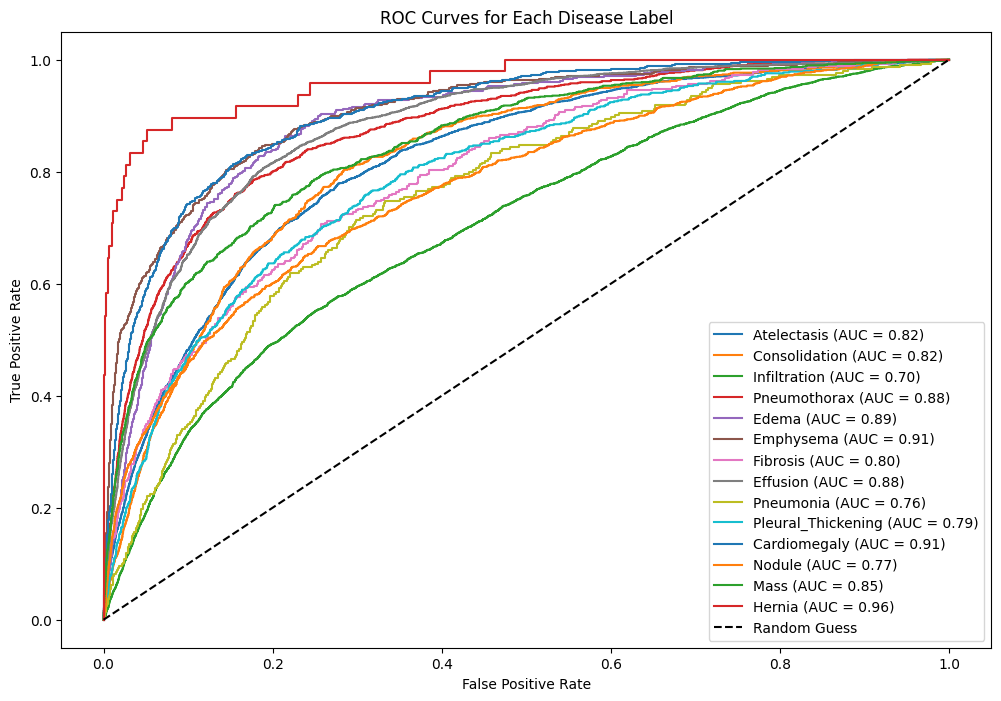

In [22]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

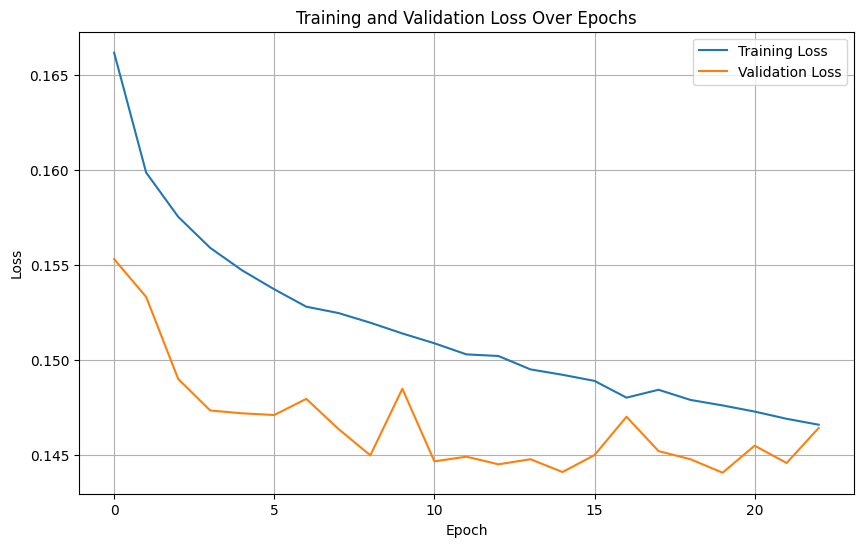

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

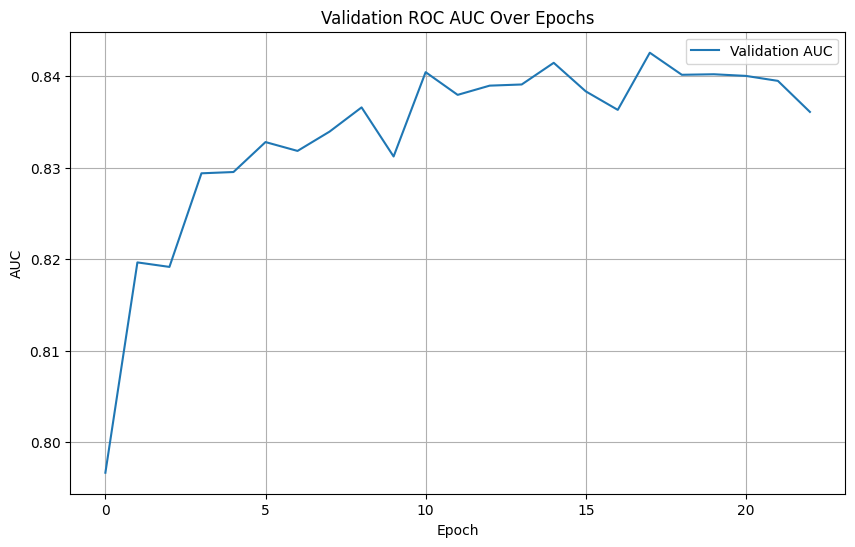

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()